In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from datetime import datetime
import random
import os
import math
# 汉字字体，优先使用楷体，找不到则使用黑体
plt.rcParams['font.sans-serif'] = ['Kaitt', 'SimHei']    
# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False

In [198]:
def f(x):
    return x.replace('T', ' ').replace('Z', '')[:-4]

format = '%Y-%m-%d %H:%M:%S'

def f2(x):
    return datetime.strptime(x, format).date()

def f3(x):
    return datetime.strptime(x, format).time()

In [308]:
def window_split(data, l_ind, window, mode):
    # 窗口切割函数
    result = []
    if mode == 'train':
        for j in range(l_ind, 0, -math.floor(window/2)):
            if (j-math.floor(window/2)) < 0:
                break
            result.append(data[j-math.floor(window/2):j+window-math.floor(window/2)].values.tolist())
        for i in range(l_ind,len(data), math.floor(window/2)):
            if i + window-1 < len(data):
                result.append(data[i:i+window].values.tolist())
    else:
        # mode == test
        for j in range(l_ind, 0, -window):
            if (j-window) < 0:
                break
            result.append(data[j-window:j].values.tolist())
        for i in range(l_ind,len(data), window):
            if i + window < len(data) -1:
                result.append(data[i:i+window].values.tolist())
    return result

In [287]:
#####
def dis_abs(x, y):
    return abs(x - y)

#dtw函数，返回样本之间的DTW距离
#A、B为时间序列，dis_func为距离策略
def estimate_twf(A, B, dis_func=dis_abs):
    N_A = len(A)
    N_B = len(B)

    D = np.zeros([N_A, N_B])
    D[0, 0] = dis_func(A[0], B[0])

    # 左边一列
    for i in range(1, N_A):
        D[i, 0] = D[i - 1, 0] + dis_func(A[i], B[0])
    # 下边一行
    for j in range(1, N_B):
        D[0, j] = D[0, j - 1] + dis_func(A[0], B[j])
    # 中间部分
    for i in range(1, N_A):
        for j in range(1, N_B):
            D[i, j] = dis_func(A[i], B[j]) + min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1])

    # 路径回溯
    i = N_A - 1
    j = N_B - 1
    count = 0
    d = np.zeros(max(N_A, N_B) * 3)
    path = []
    while True:
        if i > 0 and j > 0:
            path.append((i, j))
            m = min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1])
            if m == D[i - 1, j - 1]:
                d[count] = D[i, j] - D[i - 1, j - 1]
                i = i - 1
                j = j - 1
                count = count + 1

            elif m == D[i, j - 1]:
                d[count] = D[i, j] - D[i, j - 1]
                j = j - 1
                count = count + 1

            elif m == D[i - 1, j]:
                d[count] = D[i, j] - D[i - 1, j]
                i = i - 1
                count = count + 1

        elif i == 0 and j == 0:
            path.append((i, j))
            d[count] = D[i, j]
            count = count + 1
            break

        elif i == 0:
            path.append((i, j))
            d[count] = D[i, j] - D[i, j - 1]
            j = j - 1
            count = count + 1

        elif j == 0:
            path.append((i, j))
            d[count] = D[i, j] - D[i - 1, j]
            i = i - 1
            count = count + 1

    mean = np.sum(d) / count
    # return mean, path[::-1], D
    return mean

#####

In [283]:
def k_means_clust(data, num_clust, num_iter,dis_func=dis_abs):
    ## 步骤一: 初始化均值点
    centroids = random.sample(list(data), num_clust)
    counter = 0
    for n in range(num_iter):
        counter += 1
        # print
        # counter
        assignments = {}  #存储类别 0，1，2等类号和所包含的类的号码
        # 遍历每一个样本点 i ,添加ind的编码，视为类别
        for ind, i in enumerate(data):
            min_dist = float('inf')   #最近距离，初始定一个较大的值
            closest_clust = None     # closest_clust：最近的均值点编号
            ## 步骤二: 寻找最近的均值点
            for c_ind, j in enumerate(centroids):  #每个点和中心点的距离，共有num_clust个值
                cur_dist = estimate_twf(i, j, dis_func=dis_abs)
                if cur_dist < min_dist:         #找到了ind点距离c_ind最近
                    min_dist = cur_dist
                    closest_clust = c_ind
            ## 步骤三: 更新 ind 所属簇
            # print(closest_clust)
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust] = []
                assignments[closest_clust].append(ind)
           # recalculate centroids of clusters  ## 步骤四: 更新簇的均值点
        # print(assignments)
        for key in assignments:
            # print(key)
            clust_sum = [0 for i in range(len(data[0]))]
            #{0: [0, 2], 1: [1]},key =0,1
            for k in assignments[key]:
                # clust_sum = clust_sum + data[k]
                for i in range(len(data[k])):
                    clust_sum[i] = clust_sum[i] + data[k][i]
            centroids[key] = [m / len(assignments[key]) for m in clust_sum]
        sse = 0
        for key in assignments:
            for k in assignments[key]:
                sse = sse + estimate_twf(data[k],centroids[key])
    return centroids,assignments,sse    #返回聚类中心值，和聚类的所有点的数组序号

# train

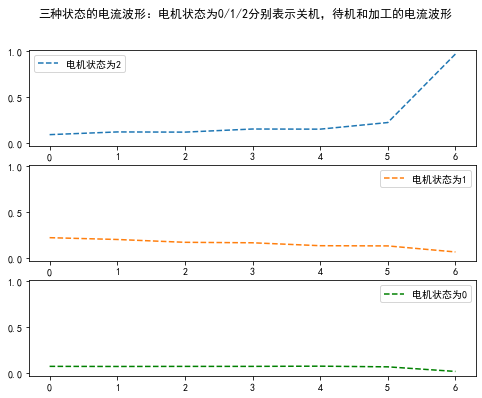

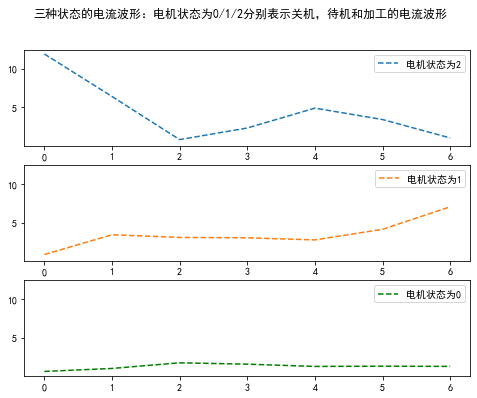

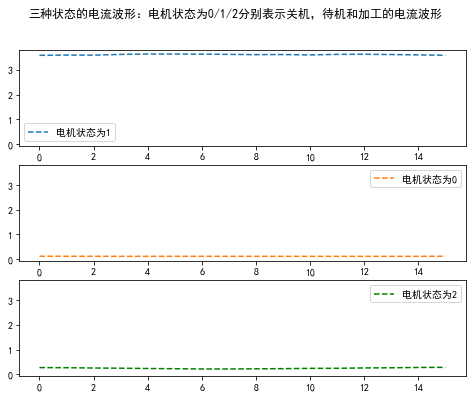

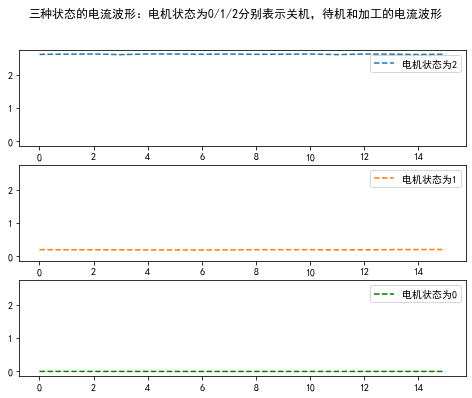

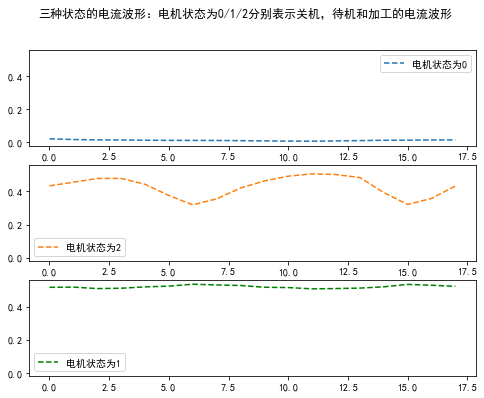

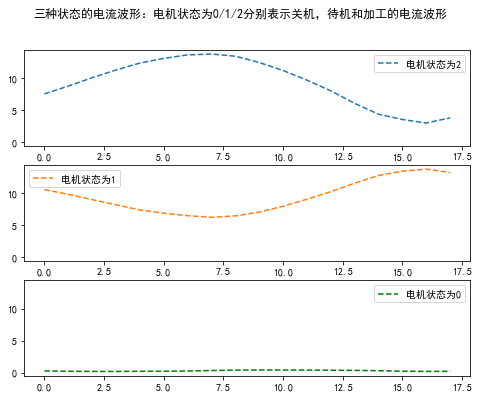

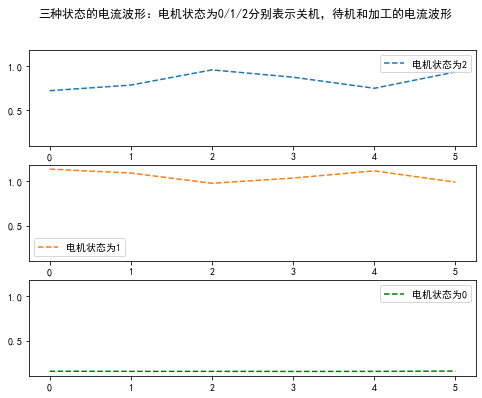

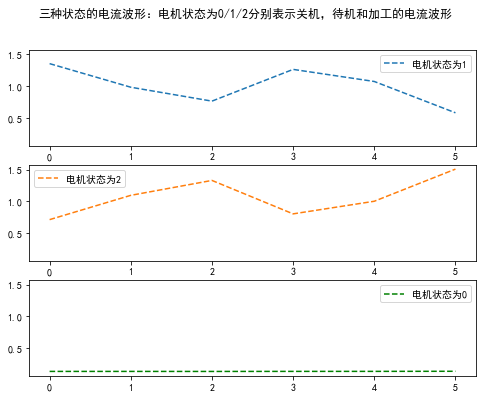

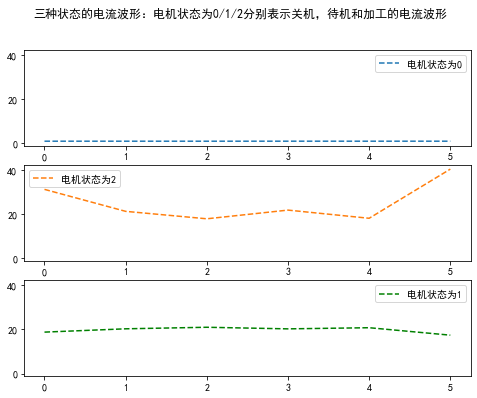

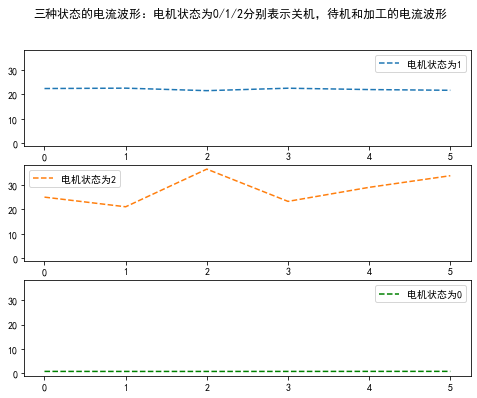

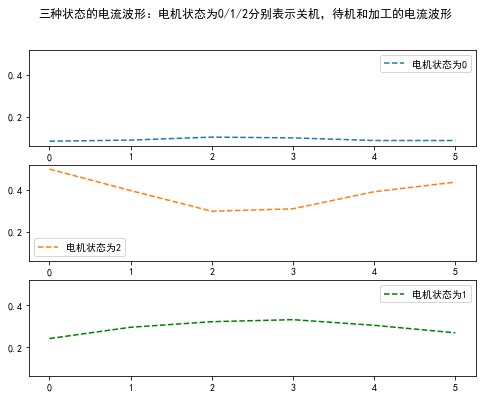

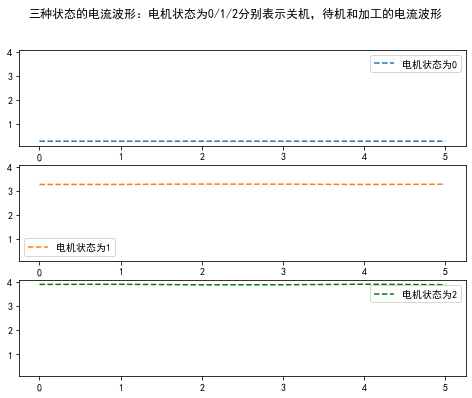

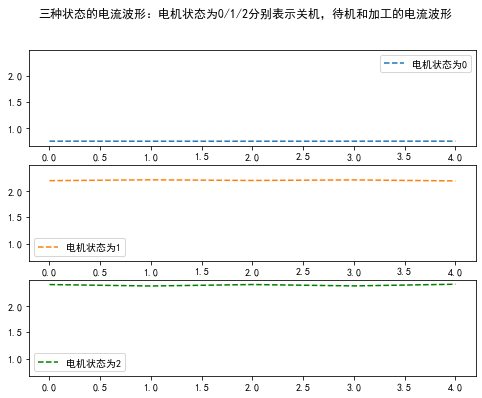

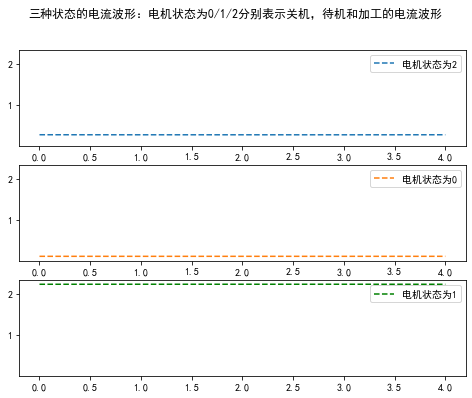

In [313]:
import os
from pathlib import Path
path = r"E:\课设4\data221204"
tools = os.listdir(path)
windows = {'冲压':7, '切磨端面':16, '加热':18, '半精锥面':6, '摩擦焊':6, '杆部抛光':6, '磨锁夹槽':5}
L_ind = {'冲压':6, '切磨端面':1015, '加热':2, '半精锥面':164, '摩擦焊':151, '杆部抛光':151, '磨锁夹槽':150}
centroids_all_machine = {}

# windows 是一样的，但是阈值是不一样的
for tool in tools:
    window = windows[tool]
    tool_path = path + "\\" + tool
    files = os.listdir(tool_path)
    l_ind = L_ind[tool]
    for file in files:
        # 只训练一个数据集
        ind = file.index('_')
        machine_name = tool + file[5:ind]
        if machine_name in centroids_all_machine:
            continue
        files_path = tool_path + "\\" + file
        train_data = pd.read_csv(files_path) # //可以读取
        
        # l_ind = Get_lind(train_data['i'])
        window_train_data = window_split(train_data['i'], window=window, l_ind=l_ind, mode='train')
        # 进行k_means训练
        centroids,assignments,sse = k_means_clust(window_train_data, num_clust=3, num_iter=5, dis_func=estimate_twf)
        centroids_all_machine[machine_name] = centroids

        # 画聚类中心图并保存
        PlotCurWave(centroids, machine_name)

In [319]:
centroids_all_machine

{'冲压125-61': [[0.08930800160836345,
   0.11874105347808599,
   0.11665701648572578,
   0.15044551668677128,
   0.14892199437072756,
   0.2208198632891034,
   0.9655186972255737],
  [0.22055923809523803,
   0.20093257142857154,
   0.17027161904761887,
   0.16514133333333308,
   0.13337371428571418,
   0.1311093333333332,
   0.0653855238095238],
  [0.07315674176560424,
   0.07199819263968096,
   0.07286550746315186,
   0.07297718986631782,
   0.07518544140101587,
   0.06799647876351649,
   0.017970240877504626]],
 '冲压125-67': [[11.87674908621804,
   6.407241453450902,
   0.8571059987099534,
   2.350292410234435,
   4.90806493227265,
   3.4400774027091323,
   1.0724575360137312],
  [0.8826841477949945,
   3.4273015494636816,
   3.0837973778307886,
   3.03531585220505,
   2.7622264600715796,
   4.131976162097777,
   7.023818831942813],
  [0.6503487291174064,
   1.0353863111206778,
   1.7617686117235485,
   1.5872383203633849,
   1.2946792913868324,
   1.3259098031926113,
   1.2997269660833

In [300]:
centroids

[[0.12543894652833182,
  0.25643735035913845,
  0.314198324022346,
  0.11560734237829205,
  0.3420039904229851,
  0.3406408619313645,
  0.350745810055866],
 [0.8168648854961827,
  0.3448480916030531,
  0.24065648854961827,
  0.3319419847328245,
  0.2692534351145038,
  0.0768793893129771,
  0.14800152671755729],
 [0.05284413094917186,
  0.0610677209692395,
  0.05908811812981118,
  0.07263333033815571,
  0.05761125587803638,
  0.06352945757330722,
  0.06220127594572754]]

In [124]:
def Get_State_Ind(centroids):
    # 区别属于哪种工作状态：根据平均值和方差！
    centroid_means = []
    centroid_stds = []
    from statistics import mean, pvariance
    for centroid in centroids:
        centroid_means.append(mean(centroid))
        centroid_stds.append(pvariance(centroid))

    shoud_down_ind = np.argmin(centroid_means)  # 关机
    work_ind = np.argmax(centroid_stds)   # 工作
    free_ind = [i for i in range(3) if i !=shoud_down_ind and i!= work_ind][0]  # 待机状态
    return [shoud_down_ind, free_ind, work_ind]

In [235]:
test_data = pd.read_csv(r"E:\课设4\data221204\加热\4.47.121-206_0501-0510.csv") 
test_data['ts'] = test_data['ts'].apply(f)
test_window_data = window_split(test_data['i'], l_ind=20006, window=11, mode='test')

In [316]:
def ThreeState(test_window_data, test_data_time,centroids, n):
    # 利用时间窗口切割电流数据，再于聚类中心计算DTW距离，并划分到相应的状态（关机-待机-工作）
    result = []
    for ind, i in enumerate(test_window_data):
        from datetime import datetime
        min_dist = float('inf')   #最近距离，初始定一个较大的值
        closest_clust = None     # closest_clust：最近的均值点编号
        ## 步骤二: 寻找最近的均值点
        for c_ind, j in enumerate(centroids):  #每个点和中心点的距离，共有num_clust个值
            cur_dist = estimate_twf(i, j, dis_func=dis_abs)
            if cur_dist < min_dist:         #找到了ind点距离c_ind最近
                min_dist = cur_dist
                closest_clust = c_ind   # 该点与c_ind最近，所以将其划分为c_ind类
        # 自己再将其划分为0，1，2
        state = Get_State_Ind(centroids).index(closest_clust)
        ## 步骤三: 更新 ind 所属簇
        # 拿到相应的时间戳
        time = test_data_time.values
        if l_ind - (ind+1)*window>0:
            begin_time = datetime.strptime(time[l_ind - (ind+1)*window], '%Y-%m-%d %H:%M:%S')
            end_time = datetime.strptime(time[l_ind - ind*window],'%Y-%m-%d %H:%M:%S')
        else:
            if l_ind + (ind+1)* window < n:
                begin_time = datetime.strptime(time[l_ind+ind*window], '%Y-%m-%d %H:%M:%S')
                end_time = datetime.strptime(time[l_ind + (ind+1)* window],'%Y-%m-%d %H:%M:%S')
            else:
                if l_ind+ind*window < n:
                    begin_time = datetime.strptime(time[l_ind+ind*window], '%Y-%m-%d %H:%M:%S')
                    end_time = datetime.strptime(time[-1],'%Y-%m-%d %H:%M:%S')

        continue_time = end_time - begin_time
        if state == 2:
            num_work = 1
        else:
            num_work = 0
        result.append([state,begin_time.date(), begin_time.time(), end_time.time(), continue_time.seconds, num_work])
    return result

# test--对所有电流数据，判断相应的状态

In [314]:
import os
from pathlib import Path
path = r"E:\课设4\data221204"
tools = os.listdir(path)
tools

['冲压', '切磨端面', '加热', '半精锥面', '摩擦焊', '杆部抛光', '磨锁夹槽']

In [318]:
import os
from pathlib import Path
path = r"E:\课设4\data221204"
tools = os.listdir(path)
windows = {'冲压':7, '切磨端面':16, '加热':18, '半精锥面':6, '摩擦焊':6, '杆部抛光':6, '磨锁夹槽':5}
L_ind = {'冲压':6, '切磨端面':1015, '加热':2, '半精锥面':164, '摩擦焊':151, '杆部抛光':151, '磨锁夹槽':150}
for tool in tools:
    window = windows[tool]
    l_ind = L_ind[tool]
    tool_path = path + "\\" + tool
    files = os.listdir(tool_path)
    for file in files:
        ind = file.index('_')
        machine_name = tool + file[5:ind]
        centroids = centroids_all_machine[machine_name]
        files_path = tool_path + "\\" + file
        new_path = r"E:\课设4\new_three_state_time" + "\\"+ tool + "\\"+file
        test_data = pd.read_csv(files_path) # //可以读取
        # l_ind = Get_lind(test_data['i'])
        test_data['ts'] = test_data['ts'].apply(f)
        # 用时间窗口切割
        test_window_data = window_split(test_data['i'], l_ind=l_ind, window=window, mode='test')
        result = pd.DataFrame(ThreeState(test_window_data, test_data['ts'], centroids, len(test_data)), columns=['state_dtw', 'date', 'begin_time', 'end_time','continue_time', 'num_work'])
        # 时间拼接
        # 输出为csv文件
        result.to_csv(new_path, index=False)
        print(new_path+"完成!")
    print(tool_path+"完成！")

已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
已经处理过了，跳过！
E:\课设4\data221204\冲压完成！
E:\课设4\new_three_state_time\切磨端面\7.101.018-34_1010-1015.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.102.018-34_1017-1022.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.103.018-34_1024-1029.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.104.018-34_1102-1107.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.105.018-34_1108-1114.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.106.018-34_1121-1126.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.107.018-34_1126-1202.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.108.018-49_0701-0705.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.109.018-49_0711-0715.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.110.018-49_0721-0725.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.111.018-49_0801-0805.csv完成!
E:\课设4\new_three_state_time\切磨端面\7.112.018-49_0811-0815.csv完成!
E:\课设4\new_

In [246]:
def PlotCurWave(x, name):
    """绘制三种状态下的电流波形"""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows=3,ncols=1,sharey=True,figsize=(8,6)) 
    fig.suptitle('三种状态的电流波形：电机状态为0/1/2分别表示关机，待机和加工的电流波形')
    
    state = Get_State_Ind(centroids).index(0)
    axes1 = axes[0]
    axes1.plot(x[0],color='#1f77b4', ls='--', label='电机状态为{state}'.format(state=state))
    axes1.legend()
    
    state = Get_State_Ind(centroids).index(1)
    axes2 = axes[1]
    axes2.plot(x[1],color='#ff7f0e', ls='--',label='电机状态为{state}'.format(state=state))
    axes2.legend()
    
    state = Get_State_Ind(centroids).index(2)
    axes3 = axes[2]
    axes3.plot(x[2],'g--', label='电机状态为{state}'.format(state=state))
    axes3.legend()
    plt.savefig('./pictures/three_state'+'//'+ name +'.jpg')
    plt.show()

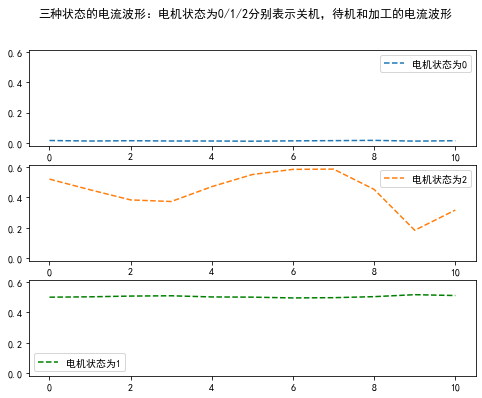

In [247]:
PlotCurWave(centroids, '加热')

上边缘： 7.23
下边缘： 0.01
非异常范围： [0.01, 7.23]
异常值（离散值）： Series([], Name: i, dtype: float64)


Text(0.5, 0, '删除异常值后')

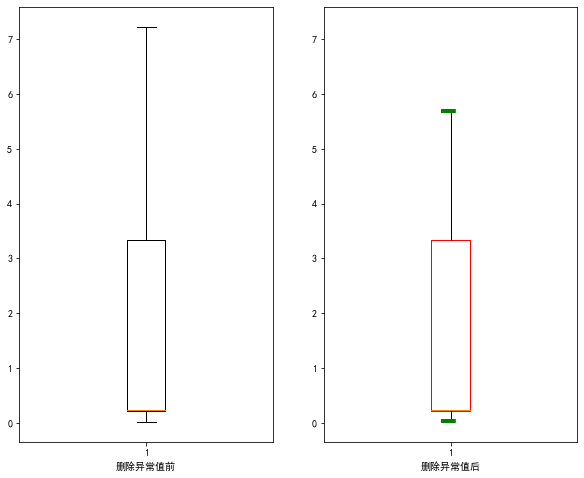

In [14]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,2,1)
bp = ax1.boxplot(y)
lower_whisker = [item.get_ydata()[1] for item in bp['whiskers']][0]
upper_whisker = [item.get_ydata()[1] for item in bp['whiskers']][1]
print("上边缘：", upper_whisker)
print("下边缘：", lower_whisker)
print("非异常范围：", [lower_whisker,upper_whisker])

##### 寻找异常值 #####
outlier = y[(y < lower_whisker) | (y > upper_whisker)]
print("异常值（离散值）：", outlier)
##### 删除异常值 ######
not_outlier = y[(y > lower_whisker) & (y < upper_whisker)]
# print(not_outlier.index.values.tolist())
# data[not_outlier.index.values.tolist()]
##### 重新检查是否还有异常值 #####
ax2 = fig.add_subplot(1,2,2,sharey =ax1)
ax2.boxplot(not_outlier,boxprops={'color':'red'},
#设置上下边缘的显示样式
capprops={'color':'green', 'lw':4, 'ls':'--'},
#设置异常值的显示样式
flierprops={'marker':'*', 'markersize': 8})
ax1.set_xlabel('删除异常值前')
ax2.set_xlabel('删除异常值后')